In [1]:
import matplotlib.pyplot as plt
#from datapackage import Package
import pandas as pd
import numpy as np
import geopandas
import plotly.express as px
import time
from scipy.stats import wilcoxon
import seaborn as sns


import os
parentDirectory = os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir))
DATA_DIR = parentDirectory +'/data/'
FIGURES_DIR = parentDirectory +'/figures/'
%matplotlib inline

In [2]:
'''
package = Package('https://datahub.io/core/country-list/datapackage.json')
from pycountry_convert import country_alpha2_to_country_name, country_name_to_country_alpha3

for resource in package.resources:
    if resource.descriptor['datahub']['type'] == 'derived/csv':
        df = geopandas.GeoDataFrame(resource.read())
 
df.columns = ['country','code']

df['country_alpha_3'] = df.code.apply(lambda x: country_name_to_country_alpha3(country_alpha2_to_country_name(x)))

from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360)


list_entries = []

for _,row in df.iterrows():
    try:
        print(row['code'])

        entry = {}
        #collect recipe
        pytrends.build_payload(kw_list=['/m/0p57p'], cat =0,geo = row['code'], timeframe='2019-01-01 2020-12-31')
        resp = pytrends.interest_over_time()
        resp = resp.reset_index()
        resp = resp.drop(['isPartial'], axis = 1)

        entry['country'] = row['country']
        entry['code2'] = row['code'] 
        entry['code3'] = row['country_alpha_3'] 
        entry['series'] = 'recipie'
        entry['values'] = resp['/m/0p57p'].values
        list_entries.append(entry)


        entry = {}
        #collect restaurant
        pytrends.build_payload(kw_list=['/m/06l8d'], cat =0,geo = row['code'], timeframe='2019-01-01 2020-12-31')
        resp = pytrends.interest_over_time()
        resp = resp.reset_index()
        resp = resp.drop(['isPartial'], axis = 1)

        entry['country'] = row['country']
        entry['code2'] = row['code'] 
        entry['code3'] = row['country_alpha_3'] 
        entry['series'] = 'restaurant'
        entry['values'] = resp['/m/06l8d'].values
        list_entries.append(entry)

        time.sleep(3)
    except:
        continue
        
df_to_plt = pd.DataFrame(list_entries)

df_to_plt.to_pickle("dataframe_map.pckl")
''';

In [3]:
def calculate_p_val(x):
    if len(x)==52*2:
        return wilcoxon(x[52:] - x[:52])[1]
    else:
        return 1

df_to_plt = pd.read_pickle(DATA_DIR + "dataframe_map.pickle")
df_to_plt['change_2020'] = df_to_plt['values'].apply(lambda x: (np.sum(x[52:]) \
                                                                - np.sum(x[:52]))/np.sum(x[:52]))

df_to_plt['p_value'] = df_to_plt['values'].apply(lambda x: calculate_p_val(x))

/Users/gligoric/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning:




In [4]:
df_to_plt['Percentage change'] = df_to_plt["change_2020"]

In [5]:
df_to_plt = df_to_plt.loc[df_to_plt['values'].apply(lambda x: len(x))==104]

In [6]:
df_to_plt['change_values'] = df_to_plt['values'].apply(lambda x: ((x[52:])- (x[:52]))/(x[:52]))

In [7]:
df_rec = df_to_plt.loc[df_to_plt['series']=='recipie'][['country','series','change_values','code2','code3','Percentage change','p_value']]
df_rec = df_rec.loc[df_rec['change_values'].apply(lambda x: sum(np.isnan(x)))==0].reset_index(drop = True)
df_rec = df_rec.loc[df_rec['change_values'].apply(lambda x: sum(np.isinf(x)))==0].reset_index(drop = True)

In [8]:
df_res = df_to_plt.loc[df_to_plt['series']=='restaurant'][['country','series','change_values','code2','code3','Percentage change','p_value']]
df_res = df_res.loc[df_res['change_values'].apply(lambda x: sum(np.isnan(x)))==0].reset_index(drop = True)
df_res = df_res.loc[df_res['change_values'].apply(lambda x: sum(np.isinf(x)))==0].reset_index(drop = True)

In [9]:
country_list = list(set((df_rec['code3'].values)).intersection(set(df_res['code3'].values)))

In [10]:
df_rec = df_rec.loc[df_rec['code3'].isin(country_list)].reset_index(drop = True)
df_res = df_res.loc[df_res['code3'].isin(country_list)].reset_index(drop = True)

In [11]:
un_member_states_193 = ['AFG','ALB','DZA','AND','AGO','ATG','ARG',
'ARM','AUS','AUT','AZE','BHS','BHR','BGD','BRB','BLR','BEL','BLZ','BEN','BTN','BOL','BIH',
'BWA','BRA','BRN','BGR','BFA','BDI','CPV','KHM','CMR','CAN','CAF','TCD',
'CHL','CHN','COL','COM','COD','COG','CRI','CIV','HRV','CUB','CYP','CZE','DNK','DJI','DMA','DOM',
'ECU','EGY','SLV','GNQ','ERI','EST','SWZ','ETH','FJI','FIN','FRA','GAB','GMB','GEO',
'DEU','GHA','GRC','GRD','GTM','GIN','GNB','GUY','HTI','HND','HUN',
'ISL','IND','IDN','IRN','IRQ','IRL','ISR','ITA','JAM','JPN','JOR','KAZ','KEN','KIR','PRK',
'KOR','KWT','KGZ','LAO','LVA''LBN','LSO','LBR','LBY','LIE','LTU','LUX''MKD','MDG','MWI','MYS','MDV','MLI','MLT','MHL','MRT',
'MUS','MEX','FSM','MDA','MCO','MNG','MNE','MAR','MOZ','MMR','NAM','NRU','NPL','NLD','NZL','NIC','NER',
'NGA','NOR','OMN','PAK','PLW','PAN','PNG','PRY','PER',
'PHL','POL','PRT','QAT','ROU','RUS','RWA','KNA','LCA','VCT','WSM','SMR','STP','SAU','SEN',
'SRB','SYC','SLE','SGP','SVK','SVN','SLB','SOM','ZAF','SSD','ESP','LKA','SDN',
'SUR','SWE','CHE','SYR','TJK','TZA','THA','TLS','TGO','TON',
'TTO','TUN','TUR','TKM','TUV','UGA','UKR','ARE','GBR','USA','URY',
'UZB','VUT','VEN','VNM','YEM','ZMB','ZWE']

In [12]:
df_rec = df_rec.loc[df_rec['code3'].isin(un_member_states_193)].reset_index(drop = True)
df_res = df_res.loc[df_res['code3'].isin(un_member_states_193)].reset_index(drop = True)

In [13]:
df_rec['series'] = df_rec['series'].replace({'recipie': 'Recipie'})
df_res['series'] = df_res['series'].replace({'restaurant': 'Restaurant'})

In [14]:
full_df = pd.concat((df_res.explode('change_values'), df_rec.explode('change_values')))
full_df['country'] = full_df['country'].apply(lambda x:  x if len(x.split(', '))==1 else x.split(', ')[1] + " " +x.split(', ')[0] )
full_df['country']  = full_df['country'].replace({'the Former Yugoslav Republic of Macedonia': 'North Macedonia'})

In [15]:
len(full_df)/2/52

129.0

<Figure size 432x288 with 0 Axes>

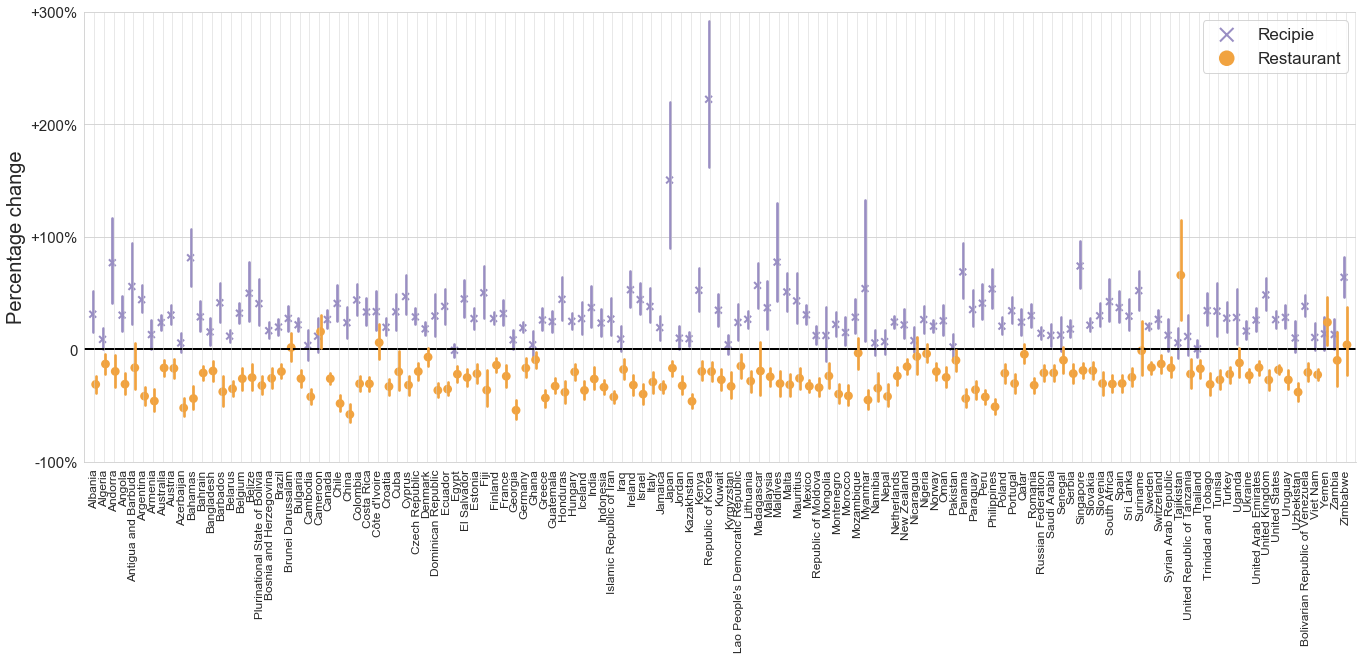

In [16]:
sns.set_style("whitegrid")
sns.despine()

bars = sns.catplot(x="country", y="change_values", kind = 'point', join = False, dodge = 0.3,
           hue="series", hue_order = ['Recipie','Restaurant'], palette=["#998ec3","#f1a340"],
            data=full_df, height = 7, aspect = 2.7, legend=False, markers = ['x','o'])


bars.set_xticklabels(rotation=90)
bars.set_xticklabels(fontsize= 12)

plt.ylim([-1,3])
plt.xlabel('')
plt.legend(markerscale = 2,loc='upper right', fontsize= 17)

plt.hlines(0,-1,130, linewidth = 2)
plt.xlim([-1,129.1])

plt.yticks([-1,0,1,2,3],["-100%","0","+100%","+200%","+300%"], fontsize= 15);
plt.ylabel('Percentage change', fontsize= 20)

for i in range(0,130):
    plt.vlines(i,-1,3, color = 'lightgray', linewidth = 0.5);


plt.savefig(FIGURES_DIR + 'statistics_map.pdf', bbox_inches='tight')

In [17]:
fig = px.choropleth(df_rec.loc[(df_rec['p_value']<0.05)], locations="code3", 
                    locationmode="ISO-3", color="Percentage change", 
                    hover_name="country", range_color=[-1,1], 
                    color_continuous_scale="RdBu",width = 900, height = 305)

fig.update(layout_coloraxis_showscale=True, layout_title_text='')
fig.update_layout(
                 margin_r = 0,margin_l = 5,margin_b = 0,margin_t = 0,# customize legend orientation & positio
    )
fig.update_geos(
    resolution=110,
    showcoastlines=True, coastlinecolor="Black",countrywidth = 0.1,
    showland=True, landcolor="Gray",
    showocean=False, oceancolor="LightBlue", countrycolor = "Black",
    #showlakes=True, lakecolor="Blue",
    #showrivers=True, rivercolor="Blue"
    center = {'lat': 30,'lon':0}
)
    

fig.write_image(FIGURES_DIR + 'recipe_map.pdf')

In [18]:
fig = px.choropleth(df_res.loc[(df_res['p_value']<0.05)], locations="code3", 
                    locationmode="ISO-3", color="Percentage change", 
                    hover_name="country", range_color=[-1,1], 
                    color_continuous_scale="RdBu",width = 900, height = 305)

fig.update(layout_coloraxis_showscale=True, layout_title_text='')
fig.update_layout(
                 margin_r = 0,margin_l = 5,margin_b = 0,margin_t = 0,# customize legend orientation & positio
    )
fig.update_geos(
    resolution=110,
    showcoastlines=True, coastlinecolor="Black",
    showland=True, landcolor="Gray",
    showocean=False, oceancolor="LightBlue",
    #showlakes=True, lakecolor="Blue",
    #showrivers=True, rivercolor="Blue"
    center = {'lat': 30,'lon':0}
)

fig.update_geos(
    countrywidth = 0.1,countrycolor = "Black"
)
    

fig.write_image(FIGURES_DIR + 'restaurant_map.pdf')